<a href="https://colab.research.google.com/github/enelene/Walmart-Recruiting---Store-Sales-Forecasting/blob/main/notebooks/model_experiment_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
# Add the directory containing your script to the Python path
sys.path.append('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main')

In [4]:
!pip install -r  drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11

In [30]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import mlflow
import mlflow.pyfunc
import optuna
import os
import dagshub

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
# from src.preprocessing import advanced_feature_engineering

In [6]:
def wmae(y_true, y_pred, is_holiday):
    """Computes the Weighted Mean Absolute Error."""
    weights = np.where(np.array(is_holiday, dtype=bool), 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)


In [7]:
try:
    train_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/train_final.csv', parse_dates=['Date'])
    validation_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/validation_final.csv', parse_dates=['Date'])
    test_df = pd.read_csv('drive/MyDrive/Colab_Notebooks/Walmart-Recruiting---Store-Sales-Forecasting-main/data/test_final.csv', parse_dates=['Date'])
    print("Successfully loaded all pre-split data files.")
except KeyError:
    print("ERROR: Make sure you have uploaded all three required CSV files.")
    raise

Successfully loaded all pre-split data files.


In [9]:
!pip install dagshub

In [11]:
import dagshub

dagshub.init(repo_owner='enelene', repo_name='Walmart-Recruiting---Store-Sales-Forecasting', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=68d51a31-97e4-449b-ae99-fef829169d04&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=6cc7487cefce3e2a92cc052ed9c5511dfce5369ad6882458d68129d954a84bce




Accessing as enelene

Initialized MLflow to track repo "enelene/Walmart-Recruiting---Store-Sales-Forecasting"

Repository enelene/Walmart-Recruiting---Store-Sales-Forecasting initialized!

In [13]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow")

os.environ['MLFLOW_TRACKING_USERNAME'] = 'enelene'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cbe8109dbe80931664d754dbd476356414fa62a0'

EXPERIMENT_NAME = "LightGBM_Training"
print(f"Experiment set to: '{EXPERIMENT_NAME}'")


Experiment set to: 'LightGBM_Training'


In [14]:
# Define Features (X) and Target (y)
TARGET = 'Weekly_Sales'
FEATURES_TO_DROP = [TARGET, 'Date']
initial_features = [col for col in train_df.columns if col not in FEATURES_TO_DROP]

# Define categorical features based on our knowledge of the data
categorical_features_initial = [
    'Store', 'Dept', 'IsHoliday', 'Year', 'Month', 'WeekOfYear', 'HasMarkdown',
    'Store_Dept', 'Type_A', 'Type_B', 'Type_C', 'IsSuperBowlWeek',
    'IsLaborDayWeek', 'IsThanksgivingWeek', 'IsChristmasWeek'
]
categorical_features_initial = [f for f in categorical_features_initial if f in train_df.columns]


In [15]:
# Convert categorical features to the correct dtype for LightGBM
for col in categorical_features_initial:
    train_df[col] = train_df[col].astype('category')

In [16]:
dagshub.init(repo_owner='enelene', repo_name='Walmart-Recruiting---Store-Sales-Forecasting', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow")

os.environ['MLFLOW_TRACKING_USERNAME'] = 'enelene'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cbe8109dbe80931664d754dbd476356414fa62a0'

EXPERIMENT_NAME = "LightGBM_Advanced_Training"
mlflow.set_experiment(EXPERIMENT_NAME)
print(f"MLflow experiment set to: '{EXPERIMENT_NAME}'")

# Custom evaluation metric (WMAE) required by the competition
def wmae(y_true, y_pred, is_holiday):
    weights = np.where(is_holiday.astype(bool), 5, 1)
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

Initialized MLflow to track repo "enelene/Walmart-Recruiting---Store-Sales-Forecasting"

Repository enelene/Walmart-Recruiting---Store-Sales-Forecasting initialized!

2025/08/01 13:59:14 INFO mlflow.tracking.fluent: Experiment with name 'LightGBM_Advanced_Training' does not exist. Creating a new experiment.


MLflow experiment set to: 'LightGBM_Advanced_Training'


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

--- Training a baseline model for feature selection ---
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6988
[LightGBM] [Info] Number of data points in the train set: 203988, number of used features: 35
[LightGBM] [Info] Start training from score 17609.587572


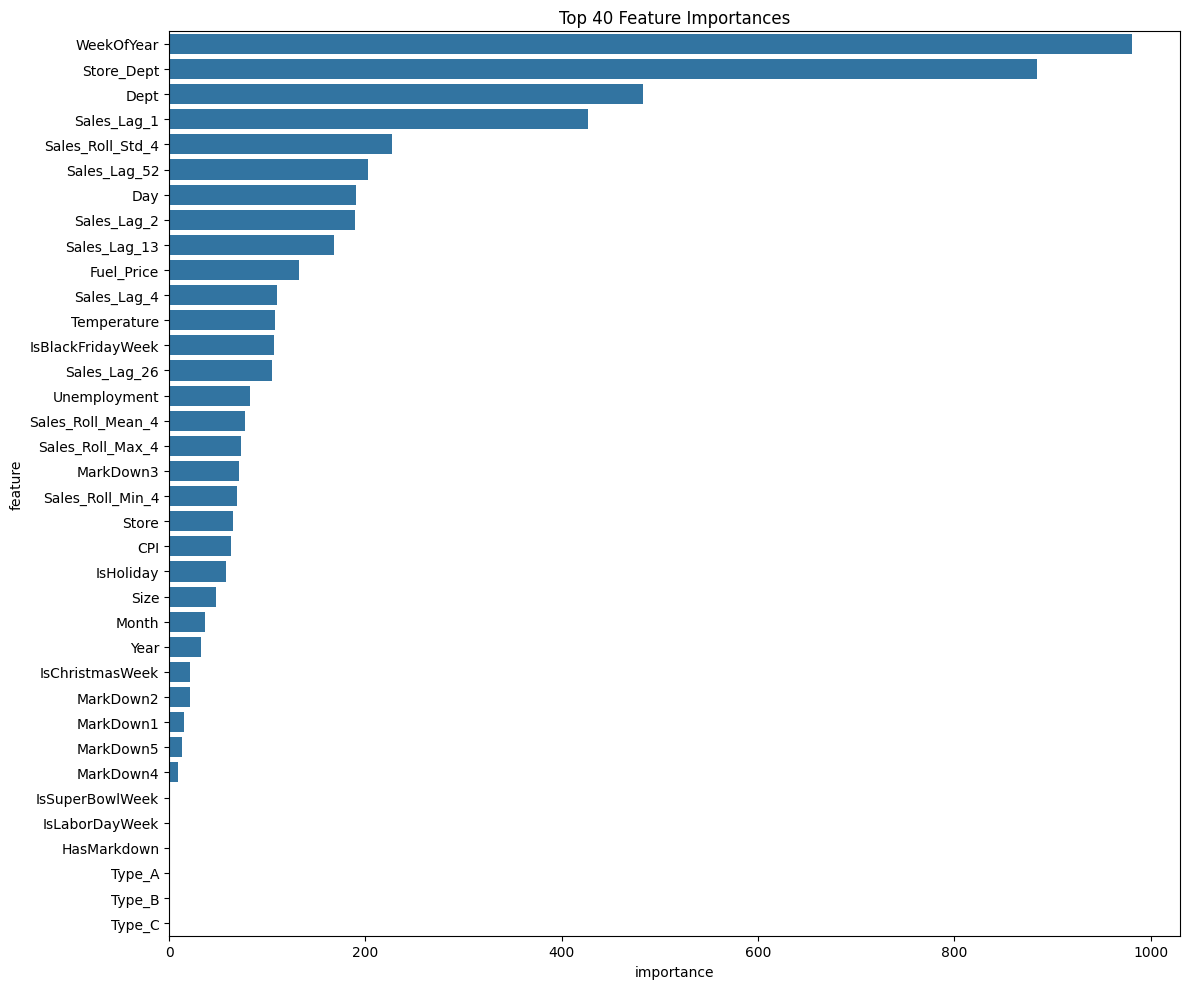


Selected top 40 features.
🏃 View run Feature_Selection at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4/runs/1fc10dde3050484f9b785e878a954c1c
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4


In [21]:
with mlflow.start_run(run_name="Feature_Selection") as run:
    print("--- Training a baseline model for feature selection ---")

    X_initial = train_df[initial_features]
    y = train_df[TARGET]

    # Use a simple TimeSeriesSplit for this preliminary step
    tscv = TimeSeriesSplit(n_splits=2)
    train_idx, val_idx = list(tscv.split(X_initial))[-1] # Use the last split

    X_train, X_val = X_initial.iloc[train_idx], X_initial.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train a simple model
    model_for_fs = lgb.LGBMRegressor(random_state=42, n_estimators=500)
    model_for_fs.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
                     eval_metric='mae',
                     callbacks=[lgb.early_stopping(50, verbose=False)],
                     categorical_feature=categorical_features_initial)

    # --- Create and Log Feature Importance Plot ---
    feature_importances = pd.DataFrame({
        'feature': X_initial.columns,
        'importance': model_for_fs.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(40))
    plt.title('Top 40 Feature Importances')
    plt.tight_layout()

    # Log the plot to MLflow
    mlflow.log_figure(plt.gcf(), "feature_importance_top40.png")
    plt.show()

    # --- Select Top N Features ---
    NUM_FEATURES_TO_SELECT = 40
    selected_features = feature_importances['feature'].head(NUM_FEATURES_TO_SELECT).tolist()
    print(f"\nSelected top {NUM_FEATURES_TO_SELECT} features.")

    # Log the list of selected features as a text file artifact
    with open("selected_features.txt", "w") as f:
        for feature in selected_features:
            f.write(f"{feature}\n")
    mlflow.log_artifact("selected_features.txt")

# Prepare final feature set for the main experiment
X = train_df[selected_features]
categorical_features = [f for f in categorical_features_initial if f in selected_features]

In [22]:
def objective(trial):
    """Optuna objective function using the selected features."""
    params = {
        'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'verbose': -1, 'n_jobs': -1, 'seed': 42
    }

    wmae_scores = []
    tscv = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='mae',
                  callbacks=[lgb.early_stopping(100, verbose=False)],
                  categorical_feature=categorical_features)

        preds = model.predict(X_val)
        is_holiday_val = X_val['IsHoliday']
        score = wmae(y_val, preds, is_holiday_val)
        wmae_scores.append(score)

    return np.mean(wmae_scores)


[I 2025-08-01 14:02:09,955] A new study created in memory with name: no-name-b5707145-8bc5-4d23-8ced-ac8a4975f8f8


--- Starting Hyperparameter Tuning with Optuna (using selected features) ---


[I 2025-08-01 14:06:26,898] Trial 0 finished with value: 2305.3206766823478 and parameters: {'learning_rate': 0.04473559911115597, 'num_leaves': 51, 'feature_fraction': 0.6422486296403765, 'bagging_fraction': 0.8631713752155377, 'bagging_freq': 6, 'lambda_l1': 0.0001967363818167324, 'lambda_l2': 0.012256783139250431}. Best is trial 0 with value: 2305.3206766823478.
[I 2025-08-01 14:09:14,150] Trial 1 finished with value: 2310.3106789146914 and parameters: {'learning_rate': 0.04445481178281694, 'num_leaves': 117, 'feature_fraction': 0.7106457008400595, 'bagging_fraction': 0.8186013978742025, 'bagging_freq': 6, 'lambda_l1': 1.970204674473197e-06, 'lambda_l2': 2.501371679485247e-06}. Best is trial 0 with value: 2305.3206766823478.
[I 2025-08-01 14:22:13,553] Trial 2 finished with value: 2231.614899494707 and parameters: {'learning_rate': 0.01111570568559244, 'num_leaves': 150, 'feature_fraction': 0.628930680971735, 'bagging_fraction': 0.7748414487375365, 'bagging_freq': 4, 'lambda_l1': 1.

🏃 View run LGBM_Tuning_and_Final_Model at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4/runs/fb38b63305f34b5f987cf914c057951a
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4


KeyboardInterrupt: 

In [ ]:

# Start a new parent run for the main experiment
with mlflow.start_run(run_name="LGBM_Tuning_and_Final_Model") as run:
    print("--- Starting Hyperparameter Tuning with Optuna (using selected features) ---")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30)

    best_params = study.best_params
    best_wmae = study.best_value

    print(f"\nBest WMAE from tuning: {best_wmae:.4f}")
    print(f"Best Parameters: {best_params}")


    mlflow.log_params(best_params)
    mlflow.log_metric("best_cv_wmae", best_wmae)

    # --- Log Optuna plots as artifacts ---
    fig_optuna_history = optuna.visualization.plot_optimization_history(study)
    mlflow.log_figure(fig_optuna_history, "optuna_optimization_history.html")

    fig_optuna_slice = optuna.visualization.plot_slice(study)
    mlflow.log_figure(fig_optuna_slice, "optuna_slice_plot.html")

In [25]:
best_params = study.best_params
best_wmae = study.best_value
print(best_params, best_wmae)

{'learning_rate': 0.01111570568559244, 'num_leaves': 150, 'feature_fraction': 0.628930680971735, 'bagging_fraction': 0.7748414487375365, 'bagging_freq': 4, 'lambda_l1': 1.2938450810838131e-05, 'lambda_l2': 1.662853047648555e-05} 2231.614899494707


In [28]:
mlflow.end_run()

🏃 View run big-stoat-292 at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4/runs/3ebf18b9677a46c2a1d7ea9f3e312a49
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4


In [29]:

# Start a new parent run for the main experiment
with mlflow.start_run(run_name="LGBM_Tuning_and_Final_Model") as run:
    print("--- Starting Hyperparameter Tuning with Optuna (using selected features) ---")
    # study = optuna.create_study(direction='minimize')
    # study.optimize(objective, n_trials=30)

    best_params = study.best_params
    best_wmae = study.best_value

    print(f"\nBest WMAE from tuning: {best_wmae:.4f}")
    print(f"Best Parameters: {best_params}")

    mlflow.log_params(best_params)
    mlflow.log_metric("best_cv_wmae", best_wmae)

    # --- Log Optuna plots as artifacts ---
    fig_optuna_history = optuna.visualization.plot_optimization_history(study)
    mlflow.log_figure(fig_optuna_history, "optuna_optimization_history.html")

    fig_optuna_slice = optuna.visualization.plot_slice(study)
    mlflow.log_figure(fig_optuna_slice, "optuna_slice_plot.html")

--- Starting Hyperparameter Tuning with Optuna (using selected features) ---

Best WMAE from tuning: 2231.6149
Best Parameters: {'learning_rate': 0.01111570568559244, 'num_leaves': 150, 'feature_fraction': 0.628930680971735, 'bagging_fraction': 0.7748414487375365, 'bagging_freq': 4, 'lambda_l1': 1.2938450810838131e-05, 'lambda_l2': 1.662853047648555e-05}
🏃 View run LGBM_Tuning_and_Final_Model at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4/runs/e0689ada3261409a8a0def2668dcc17a
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4



--- Performing Final Hold-out Validation ---
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.628930680971735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628930680971735
[LightGBM] [Warning] lambda_l2 is set=1.662853047648555e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.662853047648555e-05
[LightGBM] [Warning] lambda_l1 is set=1.2938450810838131e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2938450810838131e-05
[LightGBM] [Warning] bagging_fraction is set=0.7748414487375365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748414487375365
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq i

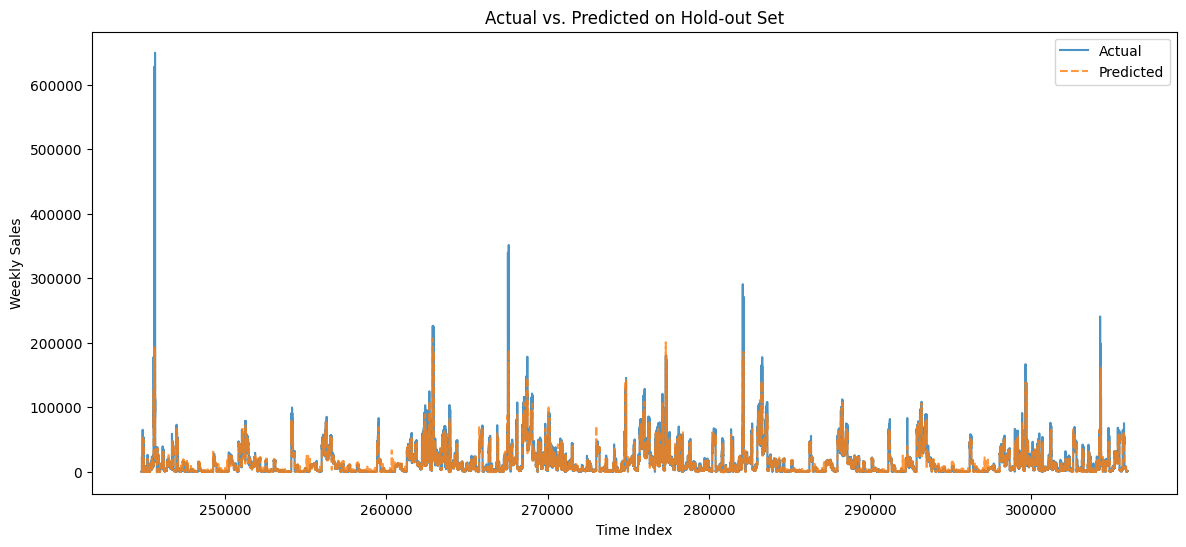

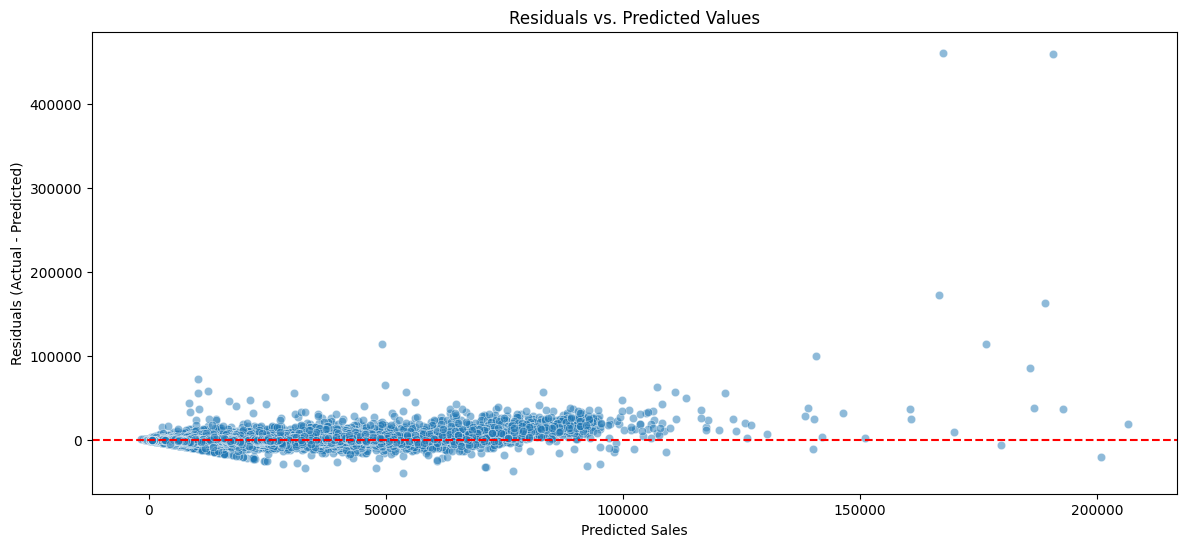


--- Training Final Model on ALL Data for Deployment ---
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.628930680971735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628930680971735
[LightGBM] [Warning] lambda_l2 is set=1.662853047648555e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.662853047648555e-05
[LightGBM] [Warning] lambda_l1 is set=1.2938450810838131e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2938450810838131e-05
[LightGBM] [Warning] bagging_fraction is set=0.7748414487375365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748414487375365
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bag

In [31]:
# Continue within the same parent MLflow run
with mlflow.start_run(run_id=run.info.run_id):
    # --- Final Hold-out Validation ---
    print("\n--- Performing Final Hold-out Validation ---")
    tscv_final = TimeSeriesSplit(n_splits=4)
    train_idx, val_idx = list(tscv_final.split(X))[-1] # Use the very last fold as a hold-out set

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    final_params = best_params
    final_params['n_estimators'] = 3000 # Use more estimators
    final_params['random_state'] = 42

    model_for_validation = lgb.LGBMRegressor(**final_params)
    model_for_validation.fit(X_train, y_train,
                             eval_set=[(X_val, y_val)],
                             callbacks=[lgb.early_stopping(150, verbose=False)],
                             categorical_feature=categorical_features)

    val_preds = model_for_validation.predict(X_val)

    # Calculate and log final validation metrics
    final_wmae = wmae(y_val, val_preds, X_val['IsHoliday'])
    final_mae = mean_absolute_error(y_val, val_preds)
    final_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

    print(f"Final Hold-out WMAE: {final_wmae:.4f}")
    print(f"Final Hold-out MAE:  {final_mae:.4f}")
    print(f"Final Hold-out RMSE: {final_rmse:.4f}")

    mlflow.log_metrics({
        "final_holdout_wmae": final_wmae,
        "final_holdout_mae": final_mae,
        "final_holdout_rmse": final_rmse
    })

    # --- Create and Log Analysis Plots ---
    # Actual vs. Predicted Plot
    plt.figure(figsize=(14, 6))
    plt.plot(y_val.index, y_val, label='Actual', alpha=0.8)
    plt.plot(y_val.index, val_preds, label='Predicted', alpha=0.8, linestyle='--')
    plt.title('Actual vs. Predicted on Hold-out Set')
    plt.xlabel('Time Index')
    plt.ylabel('Weekly Sales')
    plt.legend()
    mlflow.log_figure(plt.gcf(), "actual_vs_predicted.png")
    plt.show()

    # Residuals Plot
    residuals = y_val - val_preds
    plt.figure(figsize=(14, 6))
    sns.scatterplot(x=val_preds, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs. Predicted Values')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Residuals (Actual - Predicted)')
    mlflow.log_figure(plt.gcf(), "residuals_plot.png")
    plt.show()

    # --- Train Final Model on All Data ---
    print("\n--- Training Final Model on ALL Data for Deployment ---")
    final_model = lgb.LGBMRegressor(**final_params)
    final_model.fit(X, y, categorical_feature=categorical_features)
    print("Final model training complete.")

In [37]:
# Continue within the same parent MLflow run
with mlflow.start_run(run_id=run.info.run_id):

    # We need to save the category mappings from the training data
    training_categories = {
        col: X[col].cat.categories for col in categorical_features if hasattr(X[col], 'cat')
    }

    # Define the custom pyfunc model class (no changes here)
    class WalmartSalesPipeline(mlflow.pyfunc.PythonModel):
        def __init__(self, model, training_columns, categories):
            self.model = model
            # self._feature_engineering_fn = feature_engineering_fn
            self._training_columns = training_columns
            self._categories = categories

        def predict(self, context, model_input):
            # 1. Apply the same feature engineering as in training
            processed_input = model_input

            # 2. Enforce consistent categories to handle new or unseen values
            for col, cats in self._categories.items():
                if col in processed_input.columns:
                    processed_input[col] = pd.Categorical(processed_input[col], categories=cats, ordered=False)

            # 3. Ensure all training columns are present and in the correct order, fill missing with 0
            processed_input = processed_input.reindex(columns=self._training_columns, fill_value=0)

            # 4. Predict
            return self.model.predict(processed_input)

    print("\n--- Logging and Registering Final Model Pipeline ---")

    # Instantiate the pipeline
    pipeline_instance = WalmartSalesPipeline(final_model, selected_features, training_categories)

    # Define the raw input example for the signature and logging
    # input_example = raw_train_for_example.head(5).drop('Weekly_Sales', axis=1, errors='ignore')
    # Generate an output example by running the pipeline
    # output_example = pipeline_instance.predict(input_example)
    # Infer the signature from both the raw input and the pipeline's output
    # signature = mlflow.models.infer_signature(input_example, output_example)


/usr/local/lib/python3.11/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning:

Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.




--- Logging and Registering Final Model Pipeline ---
🏃 View run LGBM_Tuning_and_Final_Model at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4/runs/e0689ada3261409a8a0def2668dcc17a
🧪 View experiment at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/4


In [ ]:
print("Step 1: Logging model pipeline as an artifact...")
model_info = mlflow.lightgbm.log_model(
      lgb_model=final_model,
      artifact_path="lightgbm-model",
      signature=mlflow.models.infer_signature(X, final_model.predict(X))
  )
print("LightGBM model artifact logged successfully.")

# Step 2: Register the logged model artifact to the Model Registry.
model_uri = model_info.model_uri
registered_model_name = "LightGBM-Walmart-Sales"

print(f"Step 2: Registering model from '{model_uri}' to '{registered_model_name}'...")
mlflow.register_model(
    model_uri=model_uri,
    name=registered_model_name
)

# Add descriptive tags to the run
mlflow.set_tag("model_type", "LightGBM")
mlflow.set_tag("project", "Walmart Sales Forecasting")
mlflow.set_tag("features", f"selected_top_{NUM_FEATURES_TO_SELECT}")

print("\n✅ Model Pipeline successfully logged and registered to DagsHub/MLflow!")

Step 1: Logging model pipeline as an artifact...
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.628930680971735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628930680971735
[LightGBM] [Warning] lambda_l2 is set=1.662853047648555e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.662853047648555e-05
[LightGBM] [Warning] lambda_l1 is set=1.2938450810838131e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2938450810838131e-05
[LightGBM] [Warning] bagging_fraction is set=0.7748414487375365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7748414487375365


In [ ]:
# Continue within the same parent MLflow run to keep everything linked
with mlflow.start_run(run_id=run.info.run_id):
    # --- Load Raw Test Data ---
    print("\n--- Generating Submission File ---")
    # RAW_TEST_PATH = os.path.join(RAW_DATA_DIR, 'test.csv')
    # raw_test_df = pd.read_csv(RAW_TEST_PATH, parse_dates=['Date'])

    # --- Load the Packaged Pipeline Model from MLflow ---
    # This demonstrates how to use the logged model for batch inference
    logged_model_uri = f"runs:/{run.info.run_id}/lightgbm-sales-pipeline"
    loaded_pipeline = mlflow.pyfunc.load_model(logged_model_uri)

    # --- Generate Predictions ---
    # The pipeline handles all preprocessing internally!
    test_predictions = loaded_pipeline.predict(test_df)

    # --- Create Submission File ---
    submission_df = test_df.copy()
    submission_df['Weekly_Sales'] = test_predictions

    # Clip predictions at 0, as sales cannot be negative
    submission_df['Weekly_Sales'] = submission_df['Weekly_Sales'].clip(lower=0)

    # Create the required 'Id' column
    submission_df['Id'] = submission_df['Store'].astype(str) + '_' + submission_df['Dept'].astype(str) + '_' + submission_df['Date'].dt.strftime('%Y-%m-%d')

    # Select and save the final columns
    final_submission = submission_df[['Id', 'Weekly_Sales']]

    # Define a local path within DBFS to save the file
    final_submission.to_csv('submission.csv', index=False)
    display(final_submission.head())

    # --- Log Submission File as an Artifact ---
    # We remove '/dbfs' for the artifact path to be relative
    mlflow.log_artifact(('submission.csv'), "submission")
    print("\nSubmission file logged to MLflow artifacts.")
    print(f"✅ Experiment complete! Find your run at: https://dagshub.com/enelene/Walmart-Recruiting---Store-Sales-Forecasting/experiments/#/{run.info.experiment_id}/{run.info.run_id}")